In [164]:
# paquetes de la implementación
import numpy as np
import gym

# paquetes de las gráficas
import matplotlib.pyplot as plt

In [165]:
# entorno
env = gym.make('CartPole-v1')

In [166]:
#parámetros
alpha_actor = 0.001
alpha_critico = 0.01
gamma = 0.99 

In [167]:
# función de características 
def caracteristicas(estado):
    return np.append(estado, 1.0)  

# cantidad de características y acciones
n_caracteristicas = env.observation_space.shape[0] + 1  
n_acciones = env.action_space.n  

# pesos iniciales
pesos_actor = np.random.rand(n_acciones, n_caracteristicas) * 0.01
pesos_critico = np.random.rand(n_caracteristicas) * 0.01

In [168]:
# softmax 
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x)

In [169]:
# función de la política
def politica(estado):
    x = caracteristicas(estado)
    logits = pesos_actor.dot(x)
    probas = softmax(logits)
    return probas

In [170]:
# función de valor
def valor(estado):
    x = caracteristicas(estado)
    return np.dot(pesos_critico, x)

In [171]:
# función de promedio 
def promedio(datos, vnv=10): # vnv: para el promedio de los episodios
    return np.convolve(datos, np.ones(vnv)/vnv, mode='valid')

In [172]:
# hiperparámetros
n_episodios = 500
recompensas_episodios = []       
pasos_episodios = []            
pasos_totales = 0

In [173]:
for episodio in range(n_episodios):
    estado, _ = env.reset()  
    terminado = False
    recompensa_total = 0
    
    while not terminado:
        x = caracteristicas(estado)
        probas = politica(estado)
        accion = np.random.choice(n_acciones, p=probas)
        sig_estado, recompensa, terminado, trunco, _ = env.step(accion)
        terminado = terminado or trunco  
        recompensa_total = recompensa_total + recompensa
        pasos_totales = pasos_totales + 1

        # valor actual y el que sigue
        v = valor(estado)
        v_siguiente = valor(sig_estado)
        
        # (TD error)
        error_td = recompensa + gamma * v_siguiente * (1 - int(terminado)) - v
        
        # actualizar al actor
        pesos_critico = pesos_critico + alpha_critico * error_td * x

        gradiente = -probas[:, None] * x[None, :]
        gradiente[accion] = gradiente[accion] + x  
        pesos_actor = pesos_actor + alpha_actor * error_td * gradiente
        
        estado = sig_estado

    recompensas_episodios.append(recompensa_total)
    pasos_episodios.append(pasos_totales)
    
    if (episodio+1) % 25 == 0: # cada N episodios
        print(f"Episodio {episodio+1}: Recompensa Total = {recompensa_total}, Pasos Totales = {pasos_totales}")


Episodio 25: Recompensa Total = 13.0, Pasos Totales = 504
Episodio 50: Recompensa Total = 16.0, Pasos Totales = 1136
Episodio 75: Recompensa Total = 26.0, Pasos Totales = 1665
Episodio 100: Recompensa Total = 15.0, Pasos Totales = 2308
Episodio 125: Recompensa Total = 11.0, Pasos Totales = 2841
Episodio 150: Recompensa Total = 14.0, Pasos Totales = 3401
Episodio 175: Recompensa Total = 25.0, Pasos Totales = 3922
Episodio 200: Recompensa Total = 13.0, Pasos Totales = 4459
Episodio 225: Recompensa Total = 19.0, Pasos Totales = 4968
Episodio 250: Recompensa Total = 10.0, Pasos Totales = 5535
Episodio 275: Recompensa Total = 37.0, Pasos Totales = 6187
Episodio 300: Recompensa Total = 52.0, Pasos Totales = 6900
Episodio 325: Recompensa Total = 18.0, Pasos Totales = 7370
Episodio 350: Recompensa Total = 19.0, Pasos Totales = 7966
Episodio 375: Recompensa Total = 15.0, Pasos Totales = 8596
Episodio 400: Recompensa Total = 16.0, Pasos Totales = 9400
Episodio 425: Recompensa Total = 26.0, Pasos

In [174]:
prom_recom = promedio(recompensas_episodios, vnv=10)
prom_pasos = pasos_episodios[9:]

Gráfica de recompensa obtenida.
Eje x: pasos
Eje y : recompensa promedio


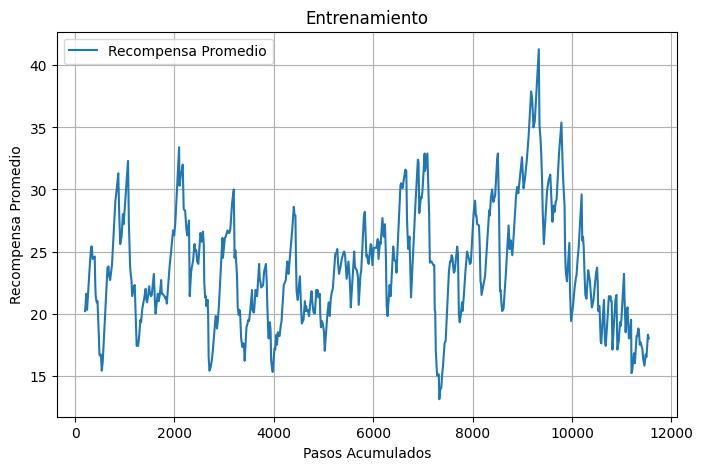

In [ ]:
print("Gráfica de recompensa obtenida.")
print("Eje x: pasos")
print("Eje y : recompensa promedio")
plt.figure(figsize=(8,5))
plt.plot(prom_pasos, prom_recom, label='Recompensa Promedio')
plt.xlabel('Pasos Acumulados')
plt.ylabel('Recompensa Promedio')
plt.title('Entrenamiento')
plt.legend()
plt.grid(True)
plt.show()

In [176]:
print("Política (pesos) del actor:")
print(pesos_actor)

Política (pesos) del actor:
[[ 0.02902616 -0.00932751 -0.01167272  0.03453811  0.04412833]
 [-0.02206137  0.01888128  0.01325435 -0.02058301 -0.03905536]]


In [ ]:
# corrida sobre 10 experiementos

def eva_politica(env, pesos_actor, n_episodios=10):
    lista_recompensas = []

    for _ in range(n_episodios):
        estado, _ = env.reset()
        terminado = False
        recompensa_total = 0
        while not terminado:
            probas = politica(estado)
            accion = np.random.choice(n_acciones, p=probas)
            sig_estado, recompensa, terminado, trunco, _ = env.step(accion)
            terminado = terminado or trunco
            recompensa_total += recompensa
            estado = sig_estado
        lista_recompensas.append(recompensa_total)
    return lista_recompensas

recompensas_evaluacion = eva_politica(env, pesos_actor, n_episodios=10)
media_recompensa = np.mean(recompensas_evaluacion)
desviacion_recompensa = np.std(recompensas_evaluacion)


print("\nResultados de la política final en 10 experimentos:")
print("----------------------------------------------")
print(f"| {'Métrica':<12} | {'Valor':<20} |")
print("----------------------------------------------")
print(f"| {'Media':<12} | {media_recompensa:<20.2f} |")
print(f"| {'Desviación':<12} | {desviacion_recompensa:<20.2f} |")
print("----------------------------------------------")



Resultados de la política final en 10 experimentos:
----------------------------------------------
| Métrica      | Valor                |
----------------------------------------------
| Media        | 24.50                |
| Desviación   | 14.72                |
----------------------------------------------
